# **Optimization Methods for Clustering**
### **Members:** Luca Tusini (2092227), Davide Christian Mancosu Bustos (2089208), Karim Eugenio Hamdar (2092041)



---
## **LOADING DATA**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def read_clq_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        edges = []

    for line in lines:
        line = line.strip()

        # Skip comments and empty lines
        if line.startswith('c') or not line:
            continue

        # Process problem line
        if line.startswith('p'):
            parts = line.split()
            if len(parts) == 4 and (parts[1] == 'edge' or parts[1] == 'col'):
                num_vertices = int(parts[2])
                num_edges = int(parts[3])
                print(f"Number of vertices: {num_vertices}")
                print(f"Number of edges: {num_edges}")

        # Process edges
        if line.startswith('e'):
            parts = line.split()
            if len(parts) == 3:
                vertex1 = int(parts[1])
                vertex2 = int(parts[2])
                edges.append((vertex1, vertex2))

    adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
    for vertex1, vertex2 in edges:
        adjacency_matrix[vertex1-1][vertex2-1] = 1
        adjacency_matrix[vertex2-1][vertex1-1] = 1

    return num_vertices, num_edges, adjacency_matrix

In [5]:
file_name = 'hamming8-4.clq'
num_vertices, num_edges, adjacency_matrix = read_clq_file(file_name)

Number of vertices: 256
Number of edges: 20864


---
## **L2 Regularized Max-Clique Problem**

In [6]:
def objective_function(x, A):
    return np.dot(x.T, np.dot(A, x)) + 0.5 * np.dot(x.T, x)

def gradient(x, A):
    return -2 * np.dot(A, x) - x

def LMO(grad, n):
    ik = np.argmin(grad)
    y = np.zeros(n)
    y[ik] = 1
    return y

def dual_gap(x, A, n):
    return np.dot(gradient(x, A), x - LMO(gradient(x, A), n))

def armijo_rule(x, grad, d_k, A, delta=0.8, gamma=0.01):
    alpha = 1
    m = 0
    while objective_function(x + alpha * d_k, A) > objective_function(x, A) + gamma * alpha * np.dot(grad, d_k):
        alpha = delta**m * alpha
        m += 1
    return alpha

# Compute the L constant as the max eigenvalue of the matrix: 2 * A + I (Hessian of f(x))
def compute_L(A):
    I = np.eye(A.shape[0])
    M = 2 * A + I
    eigenvalues = np.linalg.eigvals(M)
    L = np.max(np.abs(eigenvalues))
    return L

def plot(o, g, t):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(np.cumsum(t), g)
    ax1.set_title('Duality gap vs CPU time')
    ax1.set_xlabel('CPU time (s)')
    ax1.set_ylabel('Duality Gap')
    ax1.grid(True)

    ax2.plot(o)
    ax2.plot(g)
    ax2.set_title('Objective Fn. & Duality gap vs Iterations')
    ax2.set_xlabel('Iteration')
    ax2.grid(True)
    ax2.legend(loc='best', labels=['Objective Fn.','Duality gap'])

    plt.show()

---
### 1) Classic Frank-Wolfe Algorithm

In [7]:
def FW(A, max_iter=1000, line_search='diminishing stepsize', starting_node=0):

    n = A.shape[0]
    x = np.zeros(n)
    x[starting_node] = 1

    obj = []
    gaps = []
    cpu_times = []

    obj.append(objective_function(x, A))

    if line_search == 'lipschitz constant dependent stepsize':
        L = compute_L(A)

    for iter in range(max_iter):
        start_time = time.time()

        grad = gradient(x, A)

        y = LMO(grad, n)

        d_k = y - x

        if line_search == 'diminishing stepsize':
            alpha = 2 / (2 + iter)
        elif line_search == 'lipschitz constant dependent stepsize':
            alpha = min(-np.dot(grad, d_k) / (L * np.dot(d_k, d_k)), 1)
        elif line_search == 'armijo rule':
            alpha = armijo_rule(x, grad, d_k, A)

        x_new = x + (alpha * d_k)
        x = x_new

        obj.append(objective_function(x, A))
        gaps.append(dual_gap(x, A, n))

        end_time = time.time()
        cpu_times.append(end_time - start_time)

    clique_vertices = np.where(x > 0)[0]
    clique_size = (len(clique_vertices))

    d = {'Clique size': clique_size,
         'Obj. List': obj,
         'Duality gap List': gaps,
         'CPU time List': cpu_times}

    return d

In [11]:
starting_time = time.time()
r_FW = FW(adjacency_matrix, max_iter=1000, line_search='diminishing stepsize', starting_node=0)
endining_time = time.time()

r_FW['execution time'] = np.round(endining_time - starting_time, 2)

print('Execution time: ', r_FW['execution time'],'s\n')
print('Clique size found:', r_FW['Clique size'])

Execution time:  1.07 s

Clique size found: 16


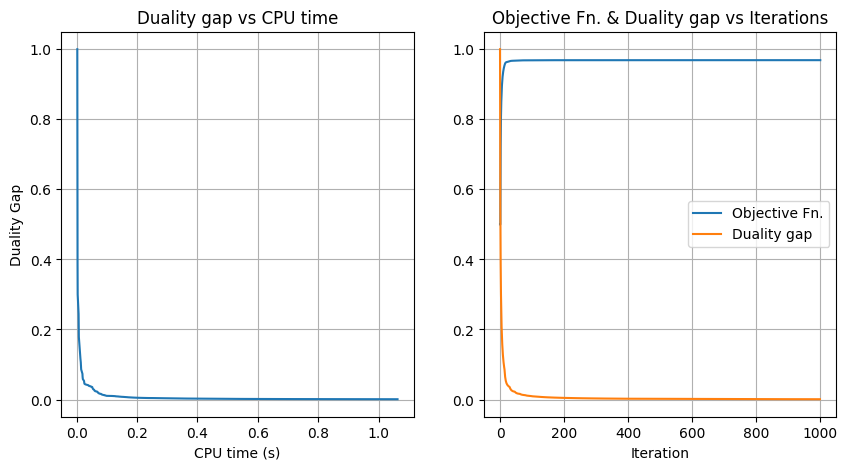

In [12]:
plot(r_FW['Obj. List'], r_FW['Duality gap List'], r_FW['CPU time List'])

---
### 2) Away-step Frank-Wolfe Algorithm

In [13]:
def away_step_FW(A, max_iter=1000, line_search='diminishing stepsize', starting_node=0):

    n = A.shape[0]
    x = np.zeros(n)

    x[starting_node] = 1
    S = {starting_node}  # Initial active set

    obj = []
    gaps = []
    cpu_times = []

    obj.append(objective_function(x,A))

    if line_search == 'lipschitz constant dependent stepsize':
        L = compute_L(A)

    for k in range(max_iter):
        start_time = time.time()
        grad = gradient(x,A)

        # Frank-Wolfe direction
        x_FW = LMO(grad, n)
        d_FW = x_FW - x

        # Away-step direction
        i_AS = max(S, key=lambda i: grad[i])
        x_AS = np.zeros(n)
        x_AS[i_AS] = 1
        d_AS = x - x_AS

        g_FW = grad @ d_FW
        g_AS = grad @ d_AS

        if g_FW <= g_AS:
            d_k = d_FW
            alpha_max = 1
        else:
            d_k = d_AS
            alpha_max = x[i_AS] / (1 - x[i_AS])

        if line_search == 'diminishing stepsize':
            alpha_k = min(alpha_max, 2 / (2 + k))
        elif line_search == 'lipschitz constant dependent stepsize':
            alpha_k = min(alpha_max, min(-np.dot(grad, d_k) / (L * np.dot(d_k, d_k)), 1))
        elif line_search == 'armijo rule':
            alpha_k = armijo_rule(x, grad, d_k, A)

        x = x + alpha_k * d_k

        obj.append(objective_function(x,A))
        gaps.append(dual_gap(x, A, n))

        S = {i for i in range(n) if x[i] > 0} # Update active set

        end_time = time.time()
        cpu_times.append(end_time - start_time)


    clique_vertices = np.where(x > 0)[0]
    clique_size = (len(clique_vertices))

    d = {'Clique size': clique_size,
         'Obj. List': obj,
         'Duality gap List': gaps,
         'CPU time List': cpu_times}

    return d

In [16]:
starting_time = time.time()
r_AS = away_step_FW(adjacency_matrix, max_iter=1000, line_search='diminishing stepsize')
endining_time = time.time()

r_AS['execution time'] = np.round(endining_time - starting_time, 2)

print('Execution time: ', r_AS['execution time'],'s\n')
print('Clique size found:', r_AS['Clique size'])

Execution time:  1.72 s

Clique size found: 16


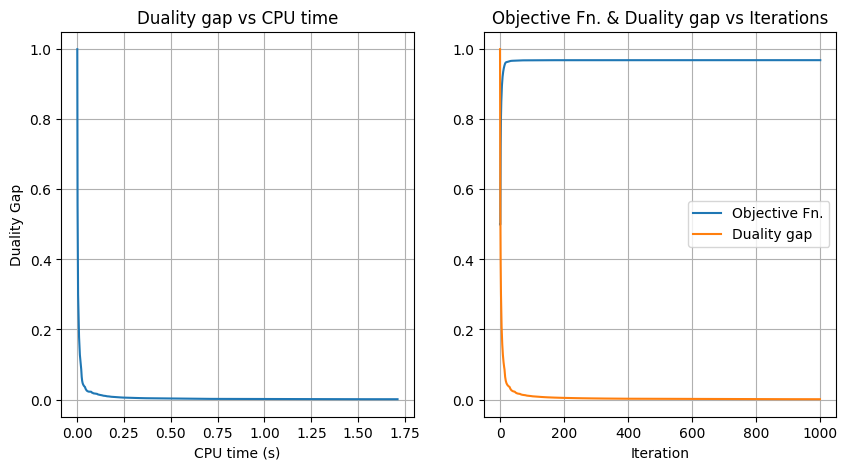

In [17]:
plot(r_AS['Obj. List'], r_AS['Duality gap List'], r_AS['CPU time List'])

---
### 3) Pair Wise Frank-Wolfe Algorithm

In [18]:
def pairwise_FW(A, max_iter=1000, line_search='diminishing stepsize', starting_node=0):

    n = A.shape[0]
    x = np.zeros(n)

    x[starting_node] = 1
    S = {starting_node}  # Initial active set

    obj = []
    gaps = []
    cpu_times = []

    obj.append(objective_function(x,A))

    if line_search == 'lipschitz constant dependent stepsize':
        L = compute_L(A)

    for k in range(max_iter):
        start_time = time.time()
        grad = gradient(x, A)

        # Frank-Wolfe direction
        x_FW = LMO(grad, n)
        d_FW = x_FW - x

        # Away-step direction
        i_AS = max(S, key=lambda i: grad[i])
        x_AS = np.zeros(n)
        x_AS[i_AS] = 1
        d_AS = x - x_AS

        # Pairwise FW direction
        d_k = d_FW + d_AS

        alpha_max_candidates = [-x[i] / d_k[i] for i in range(n) if d_k[i] < 0]
        alpha_max = min(alpha_max_candidates) if alpha_max_candidates else 1.0


        if line_search == 'diminishing stepsize':
            alpha_k = min(alpha_max, 2 / (2 + k))
        elif line_search == 'lipschitz constant dependent stepsize':
            alpha_k = min(alpha_max, min(-np.dot(grad, d_k) / (L * np.dot(d_k, d_k)), 1))
        elif line_search == 'armijo rule':
            alpha_k = armijo_rule(x, grad, d_k, A)

        x = x + alpha_k * d_k

        obj.append(objective_function(x,A))
        gaps.append(dual_gap(x, A, n))

        S = {i for i in range(n) if x[i] > 0} # Update active set

        end_time = time.time()
        cpu_times.append(end_time - start_time)


    clique_vertices = np.where(x > 0)[0]
    clique_size = (len(clique_vertices))

    d = {'Clique size': clique_size,
         'Obj. List': obj,
         'Duality gap List': gaps,
         'CPU time List': cpu_times}

    return d

In [21]:
starting_time = time.time()
r_PW = pairwise_FW(adjacency_matrix, max_iter=1000, line_search='diminishing stepsize', starting_node=0)
endining_time = time.time()

r_PW['execution time'] = np.round(endining_time - starting_time, 2)

print('Execution time: ', r_PW['execution time'],'s\n')
print('Clique size found:', r_PW['Clique size'])

Execution time:  1.5 s

Clique size found: 16


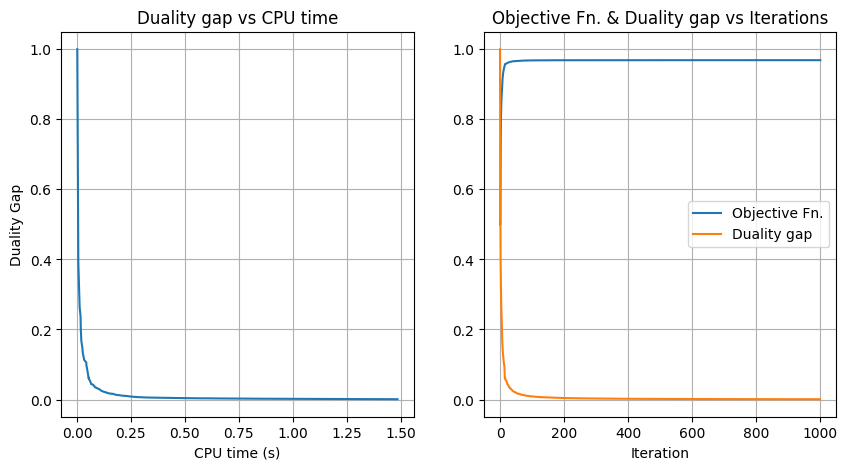

In [22]:
plot(r_PW['Obj. List'], r_PW['Duality gap List'], r_PW['CPU time List'])

---
### 4) Model Comparison

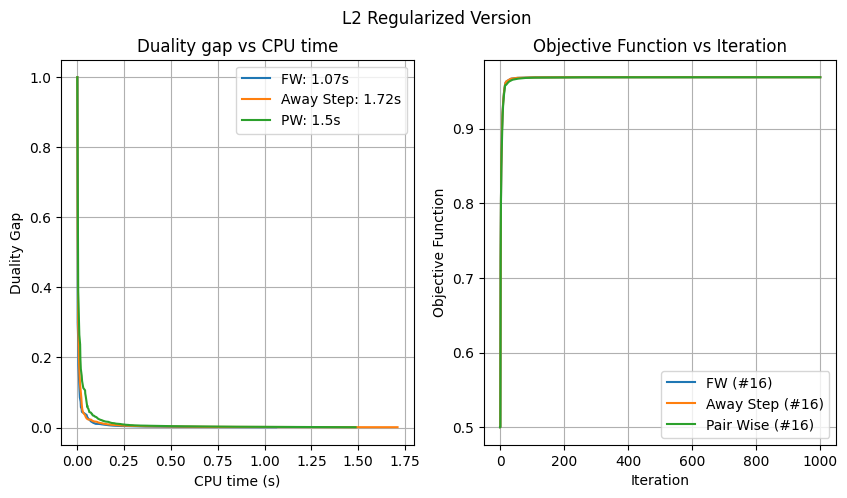

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('L2 Regularized Version')

ax1.plot(np.cumsum(r_FW['CPU time List']), r_FW['Duality gap List'])
ax1.plot(np.cumsum(r_AS['CPU time List']), r_AS['Duality gap List'])
ax1.plot(np.cumsum(r_PW['CPU time List']), r_PW['Duality gap List'])
ax1.set_title('Duality gap vs CPU time')
ax1.set_xlabel('CPU time (s)')
ax1.set_ylabel('Duality Gap')
ax1.grid(True)
ax1.legend(loc='best', labels=[f"FW: {r_FW['execution time']}s", f"Away Step: {r_AS['execution time']}s", f"PW: {r_PW['execution time']}s"])

ax2.plot(r_FW['Obj. List'])
ax2.plot(r_AS['Obj. List'])
ax2.plot(r_PW['Obj. List'])
ax2.set_title('Objective Function vs Iteration')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Function')
ax2.grid(True)
ax2.legend(loc='best', labels=[f"FW (#{r_FW['Clique size']})", f"Away Step (#{r_AS['Clique size']})", f"Pair Wise (#{r_PW['Clique size']})"])

plt.show()

---
## **L0 Regularized Max-Clique Problem**

In [46]:
def objective_function_2(x, A, alpha2, beta):
    return np.dot(x.T, np.dot(A, x)) + (alpha2 * np.sum(np.exp(-beta * x) - 1))

def gradient_2(x, A, alpha2, beta):
    return -2 * np.dot(A, x) + alpha2 * beta * np.exp(-beta * x)

def LMO(grad, n):
    ik = np.argmin(grad)
    y = np.zeros(n)
    y[ik] = 1
    return y

def dual_gap_2(x, A, n, alpha2, beta):
    return np.dot(gradient_2(x, A, alpha2, beta), x - LMO(gradient_2(x, A, alpha2, beta), n))

def armijo_rule(x, grad, d_k, A, delta=0.8, gamma=0.01, alpha2=0.05, beta=0.5):
    alpha = 1
    m = 0
    while objective_function_2(x + alpha * d_k, A, alpha2, beta) > objective_function_2(x, A, alpha2, beta) + gamma * alpha * np.dot(grad, d_k):
        alpha = delta**m * alpha
        m += 1
    return alpha

# Compute the L constant as: 2∥A∥ + α2*β
def compute_L_2(A, alpha2, beta):
    A_norm = np.linalg.norm(A, ord=2)  # 2-norm of A
    L = 2 * A_norm + alpha2 * beta
    return L

def plot(o, g, t):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(np.cumsum(t), g)
    ax1.set_title('Duality gap vs CPU time')
    ax1.set_xlabel('CPU time (s)')
    ax1.set_ylabel('Duality Gap')
    ax1.grid(True)

    ax2.plot(o)
    ax2.plot(g)
    ax2.set_title('Objective Fn. & Duality gap vs Iterations')
    ax2.set_xlabel('Iteration')
    ax2.grid(True)
    ax2.legend(loc='best', labels=['Objective Fn.','Duality gap'])

    plt.show()

---
### 1) Classic Frank-Wolfe Algorithm

In [25]:
def FW_2(A, max_iter=1000, line_search='diminishing stepsize', starting_node=0, alpha2=0.05, beta=5):

    n = A.shape[0]
    x = np.zeros(n)
    x[starting_node] = 1

    obj = []
    gaps = []
    cpu_times = []

    obj.append(objective_function_2(x, A, alpha2, beta))

    if line_search == 'lipschitz constant dependent stepsize':
        L = compute_L_2(A, alpha2, beta)

    for iter in range(max_iter):
        start_time = time.time()

        grad = gradient_2(x, A, alpha2, beta)

        y = LMO(grad, n)

        d_k = y - x

        if line_search == 'diminishing stepsize':
            alpha = 2 / (2 + iter)
        elif line_search == 'lipschitz constant dependent stepsize':
            alpha = min(-np.dot(grad, d_k) / (L * np.dot(d_k, d_k)), 1)
        elif line_search == 'armijo rule':
            alpha = armijo_rule(x, grad, d_k, A, alpha2, beta)

        x_new = x + (alpha * d_k)
        x = x_new

        obj.append(objective_function_2(x, A, alpha2, beta))
        gaps.append(dual_gap_2(x, A, n, alpha2, beta))

        end_time = time.time()
        cpu_times.append(end_time - start_time)

    clique_vertices = np.where(x > 0)[0]
    clique_size = (len(clique_vertices))

    d = {'Clique size': clique_size,
         'Obj. List': obj,
         'Duality gap List': gaps,
         'CPU time List': cpu_times}

    return d

In [28]:
starting_time = time.time()
r_FW_2 = FW_2(adjacency_matrix, max_iter=1000, line_search='diminishing stepsize', alpha2=0.05, beta=0.5)
endining_time = time.time()

r_FW_2['execution time'] = np.round(endining_time - starting_time, 2)

print('Execution time: ', r_FW_2['execution time'],'s\n')
print('Clique size found:', r_FW_2['Clique size'])

Execution time:  1.07 s

Clique size found: 16


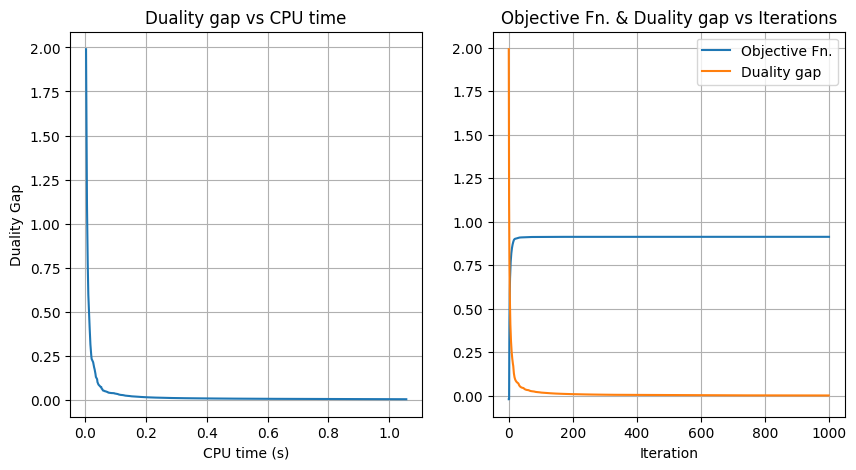

In [29]:
plot(r_FW_2['Obj. List'], r_FW_2['Duality gap List'], r_FW_2['CPU time List'])

---
### 2) Away-step Frank-Wolfe Algorithm

In [37]:
def away_step_FW_2(A, max_iter=1000, line_search='diminishing stepsize', starting_node=0, alpha2=0.05, beta=0.5):

    n = A.shape[0]
    x = np.zeros(n)

    x[starting_node] = 1
    S = {starting_node}  # Initial active set

    obj = []
    gaps = []
    cpu_times = []

    obj.append(objective_function_2(x,A, alpha2, beta))

    if line_search == 'lipschitz constant dependent stepsize':
        L = compute_L_2(A, alpha2, beta)

    for k in range(max_iter):
        start_time = time.time()
        grad = gradient_2(x, A, alpha2, beta)

        # Frank-Wolfe direction
        x_FW = LMO(grad, n)
        d_FW = x_FW - x

        # Away-step direction
        i_AS = max(S, key=lambda i: grad[i])
        x_AS = np.zeros(n)
        x_AS[i_AS] = 1
        d_AS = x - x_AS

        g_FW = grad @ d_FW
        g_AS = grad @ d_AS

        if g_FW <= g_AS:
            d_k = d_FW
            alpha_max = 1
        else:
            d_k = d_AS
            alpha_max = x[i_AS] / (1 - x[i_AS])

        if line_search == 'diminishing stepsize':
            alpha_k = min(alpha_max, 2 / (2 + k))
        elif line_search == 'lipschitz constant dependent stepsize':
            alpha_k = min(alpha_max, min(-np.dot(grad, d_k) / (L * np.dot(d_k, d_k)), 1))
        elif line_search == 'armijo rule':
            alpha_k = armijo_rule(x, grad, d_k, A, alpha2, beta)

        x = x + alpha_k * d_k

        obj.append(objective_function_2(x,A, alpha2, beta))
        gaps.append(dual_gap_2(x, A, n, alpha2, beta))

        S = {i for i in range(n) if x[i] > 0} # Update active set

        end_time = time.time()
        cpu_times.append(end_time - start_time)


    clique_vertices = np.where(x > 0)[0]
    clique_size = (len(clique_vertices))

    d = {'Clique size': clique_size,
         'Obj. List': obj,
         'Duality gap List': gaps,
         'CPU time List': cpu_times}

    return d

In [45]:
starting_time = time.time()
r_AS_2 = away_step_FW_2(adjacency_matrix, max_iter=1000, line_search='diminishing stepsize', alpha2=0.05, beta=0.5)
endining_time = time.time()

r_AS_2['execution time'] = np.round(endining_time - starting_time, 2)

print('Execution time: ', r_AS_2['execution time'],'s\n')
print('Clique size found:', r_AS_2['Clique size'])

Execution time:  0.71 s

Clique size found: 16


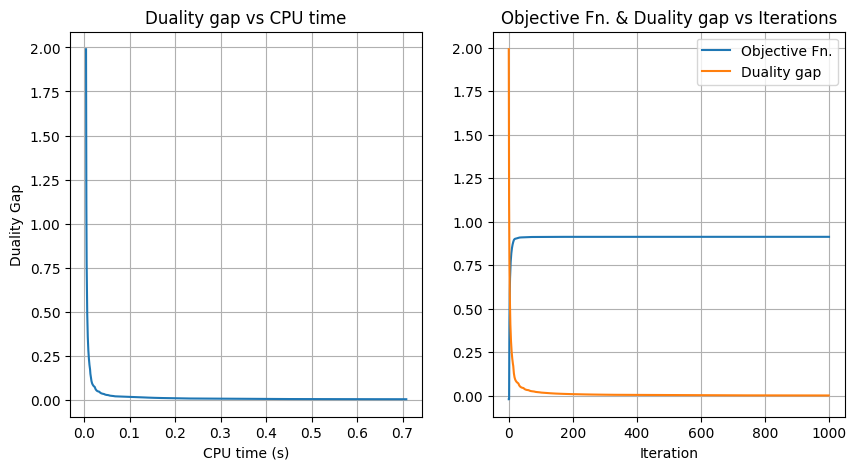

In [47]:
plot(r_AS_2['Obj. List'], r_AS_2['Duality gap List'], r_AS_2['CPU time List'])

---
### 3) Pair Wise Frank-Wolfe Algorithm

In [48]:
def pairwise_FW_2(A, max_iter=1000, line_search='diminishing stepsize', starting_node=0, alpha2=0.05, beta=0.5):

    n = A.shape[0]
    x = np.zeros(n)

    x[starting_node] = 1
    S = {starting_node}  # Initial active set

    obj = []
    gaps = []
    cpu_times = []

    obj.append(objective_function_2(x, A, alpha2, beta))

    if line_search == 'lipschitz constant dependent stepsize':
        L = compute_L_2(A, alpha2, beta)

    for k in range(max_iter):
        start_time = time.time()
        grad = gradient_2(x, A, alpha2, beta)

        # Frank-Wolfe direction
        x_FW = LMO(grad, n)
        d_FW = x_FW - x

        # Away-step direction (maximizing over the active set)
        i_AS = max(S, key=lambda i: grad[i])
        x_AS = np.zeros(n)
        x_AS[i_AS] = 1
        d_AS = x - x_AS

        # Pairwise FW direction
        d_k = d_FW + d_AS

        alpha_max_candidates = [-x[i] / d_k[i] for i in range(n) if d_k[i] < 0]
        alpha_max = min(alpha_max_candidates) if alpha_max_candidates else 1.0

        if line_search == 'diminishing stepsize':
            alpha_k = min(alpha_max, 2 / (2 + k))
        elif line_search == 'lipschitz constant dependent stepsize':
            alpha_k = min(alpha_max, min(-np.dot(grad, d_k) / (L * np.dot(d_k, d_k)), 1))
        elif line_search == 'armijo rule':
            alpha = armijo_rule(x, grad, d_k, A, alpha2, beta)

        x = x + alpha_k * d_k

        obj.append(objective_function_2(x, A, alpha2, beta))
        gaps.append(dual_gap_2(x, A, n, alpha2, beta))

        S = {i for i in range(n) if x[i] > 0} # Update active set

        end_time = time.time()
        cpu_times.append(end_time - start_time)


    clique_vertices = np.where(x > 0)[0]
    clique_size = (len(clique_vertices))

    d = {'Clique size': clique_size,
         'Obj. List': obj,
         'Duality gap List': gaps,
         'CPU time List': cpu_times}

    return d

In [51]:
starting_time = time.time()
r_PW_2 = pairwise_FW_2(adjacency_matrix, max_iter=1000, line_search='diminishing stepsize', alpha2=0.05, beta=0.5)
endining_time = time.time()

r_PW_2['execution time'] = np.round(endining_time - starting_time, 2)

print('Execution time: ', r_PW_2['execution time'],'s\n')
print('Clique size found:', r_PW_2['Clique size'])

Execution time:  1.14 s

Clique size found: 16


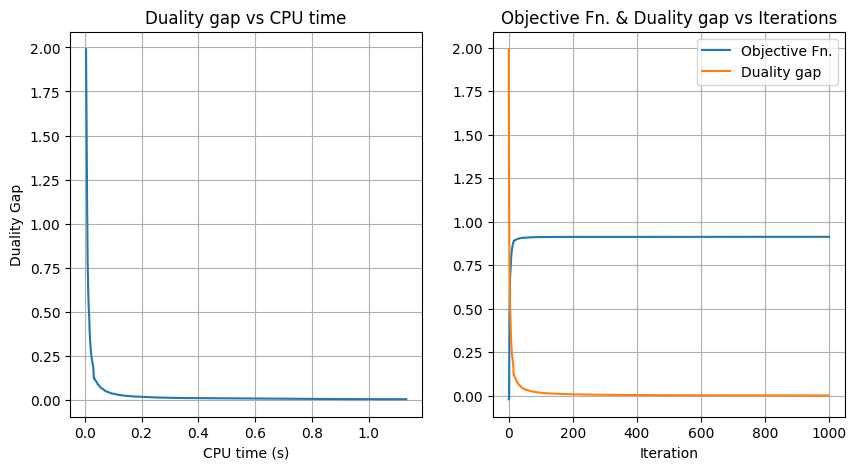

In [52]:
plot(r_PW_2['Obj. List'], r_PW_2['Duality gap List'], r_PW_2['CPU time List'])

---
### 4) Model Comparison

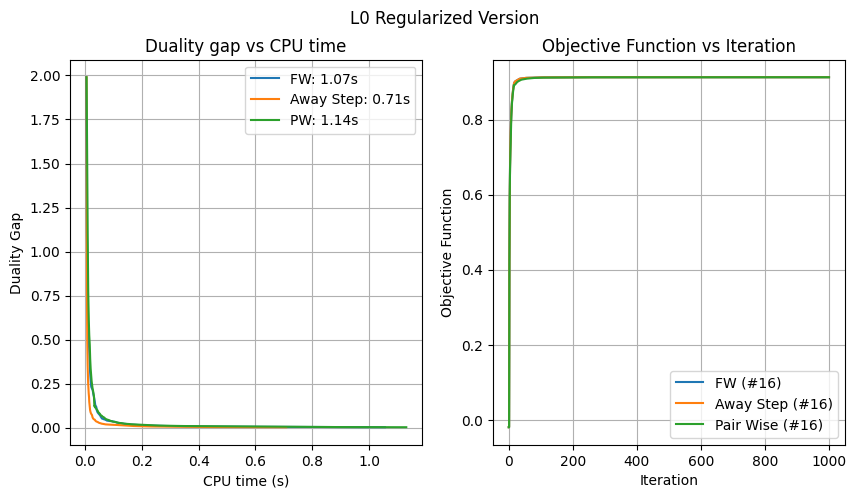

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('L0 Regularized Version')

ax1.plot(np.cumsum(r_FW_2['CPU time List']), r_FW_2['Duality gap List'])
ax1.plot(np.cumsum(r_AS_2['CPU time List']), r_AS_2['Duality gap List'])
ax1.plot(np.cumsum(r_PW_2['CPU time List']), r_PW_2['Duality gap List'])
ax1.set_title('Duality gap vs CPU time')
ax1.set_xlabel('CPU time (s)')
ax1.set_ylabel('Duality Gap')
ax1.grid(True)
ax1.legend(loc='best', labels=[f"FW: {r_FW_2['execution time']}s", f"Away Step: {r_AS_2['execution time']}s", f"PW: {r_PW_2['execution time']}s"])

ax2.plot(r_FW_2['Obj. List'])
ax2.plot(r_AS_2['Obj. List'])
ax2.plot(r_PW_2['Obj. List'])
ax2.set_title('Objective Function vs Iteration')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective Function')
ax2.grid(True)
ax2.legend(loc='best', labels=[f"FW (#{r_FW_2['Clique size']})", f"Away Step (#{r_AS_2['Clique size']})", f"Pair Wise (#{r_PW_2['Clique size']})"])

plt.show()